How to estimate noise in High-Frequency radar radial measurements
===================

This tutuorial shows how to estimate noise from High-Freuency data. It reproduces the calculations and figures of the paper:

* Jordi Isern-Fontanet, Lucía Quirós-Collazos, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Data-Driven Noise Estimation for Individual High-Frequency Radar Stations**. Submitted to *J. Atmos. Oceanic Technol.*

This turtorial uses the dataset:

* Lucía Quirós-Collazos, Jordi Isern-Fontanet, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Radial velocities for noise estimation of ICATMAR HF radar stations (v1.0)** https://doi.org/10.20350/digitalCSIC/17704

In [1]:
# System modules

import os
import glob
import sys

# Import scientific modules

import numpy as np
import xarray as xr

# Graphical packages

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS

# Each time a module is modified it is releaded

%load_ext autoreload
%autoreload 2

# Inline ploting

%matplotlib inline

# Parameters

Set the parameters necessary to run the notebook. Download the data set from https://doi.org/10.20350/digitalCSIC/17704 and modify `datapath` accordingly.

In [2]:
datapath = '/Users/jisern/Recerca/Data/Radar/L2B/'

Graphical information and objects

In [3]:
# Default color cycle

refcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Land mask for maps

land = NaturalEarthFeature(category='physical',
                           name='land',
                           scale='10m',
                           facecolor=COLORS['land'])
# Ocean mask for maps

ocean = NaturalEarthFeature(category='physical',
                            name='ocean',
                            scale='10m',
                            facecolor=COLORS['water'])

# Load and prepare the data

Get the list of stations and files

In [4]:
hfrfiles = {}            # Data files

for file in glob.glob(datapath + 'RDLm_????_*l2b.nc'):
    name = os.path.basename(file).split('_')[1]
    hfrfiles.update({name:file}) 
    print(name + ':', file)

PBCN: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_PBCN_20231201_20250529_l2b.nc
AREN: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_AREN_20231201_20250529_l2b.nc
GNST: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_GNST_20231201_20250529_l2b.nc
CREU: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_CREU_20230501_20250529_l2b.nc
BEGU: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_BEGU_20230401_20250529_l2b.nc


Read the data

In [5]:
hfrdata = {}              # Radar data

for station in hfrfiles.keys():
    hfrdata.update({station: xr.open_dataset(hfrfiles[station], engine="netcdf4")})

Sort the stations starting from the northrenmost one

In [6]:
hfrstations = []           # List of available stations sorted from North to south
hfrlon0 = []               # Longitude of each station
hfrlat0 = []               # Latitude of each station

# Extract the location of the station

for station in hfrfiles.keys():
    res = hfrdata[station].attrs['Origin'].split(' ')
    hfrlat0.append(float(res[0]))
    hfrlon0.append(float(res[-1]))
    hfrstations.append(station)

# Convert to numpy arrays and sort

index = np.argsort(hfrlat0)[::-1]

hfrstations = np.array(hfrstations)[index]
hfrlon0 = np.array(hfrlon0)[index]
hfrlat0 = np.array(hfrlat0)[index]

Assign colors to each station

In [7]:
hfrcolors = {}           # Colors for each HFR station

for i, station in enumerate(hfrstations):
    hfrcolors.update({station: refcolors[i]})

Get the number of valid points at each position using the Primary Flag ('PRIM'). 

In [8]:
for station in hfrdata.keys():
    hfrdata[station]['nobs'] = hfrdata[station]['PRIM'].sum(dim='time').astype(int)
    hfrdata[station]['nobs'].attrs["long_name"] = 'Number of observations'

In [44]:
hfrfiles = {}            # Data files
hfrdata = {}              # Radar data

print('Loading data:')

for file in glob.glob(datapath + 'RDLm_????_*l2b.nc')[:1]:

    # Get the station name
    
    station = os.path.basename(file).split('_')[1]
    hfrfiles.update({station:file}) 
    print('--', station + ':', file)

    # Read the data

    ds = xr.open_dataset(hfrfiles[station], engine="netcdf4")

    # Input files only has lat/lon when there were measurents. Extract all possible lat/lon. Data
    # gaps contain nan

    lon = ds['lon'].mean(dim='time')
    lat = ds['lat'].mean(dim='time')

    # Remove unnecessary variables and those thet will be modifued (lat/lon)

    ds = ds.drop_vars(['lon', 'lat'])

    # Substitute lat/lon in the dataset by the new values

    ds.coords['lon'] = lon
    ds.coords['lat'] = lat

    # Add some extra information

    ds.attrs['input_file'] = file
    
    # Save the data


print('Done')

Loading data:
-- PBCN: /Users/jisern/Recerca/Data/Radar/L2B/RDLm_PBCN_20231201_20250529_l2b.nc
Done


In [45]:
print(ds)
#print(lon)
#print(lat)

<xarray.Dataset>
Dimensions:  (bearing: 72, range: 68, time: 9651)
Coordinates:
  * bearing  (bearing) int16 2 7 12 17 22 27 32 ... 327 332 337 342 347 352 357
  * range    (range) float32 3.329 4.993 6.657 8.321 ... 109.8 111.5 113.2 114.8
  * time     (time) datetime64[ns] 2023-12-22T11:00:00 ... 2025-05-29T14:00:00
    lon      (range, bearing) float64 2.175 2.179 2.182 ... 1.861 1.98 2.101
    lat      (range, bearing) float64 41.38 41.38 41.38 ... 42.35 42.37 42.38
Data variables: (12/24)
    VELU     (time, range, bearing) float32 ...
    VELV     (time, range, bearing) float32 ...
    VFLG     (time, range, bearing) float32 ...
    ESPC     (time, range, bearing) float32 ...
    ETMP     (time, range, bearing) float32 ...
    EDTP     (time, range, bearing) float32 ...
    ...       ...
    Q202     (time, range, bearing) float32 ...
    Q206     (time, range, bearing) float32 ...
    Q205     (time, range, bearing) float32 ...
    Q207     (time, range, bearing) float32 ...
   

# Estimate noise

# Figures

Plot the general characteristics of the data

<xarray.DataArray 'lon' (range: 68, bearing: 72)>
array([[2.1754, 2.1789, 2.1823, ..., 2.1651, 2.1685, 2.172 ],
       [2.1761, 2.1813, 2.1865, ..., 2.1606, 2.1657, 2.1709],
       [2.1768, 2.1838, 2.1906, ..., 2.1561, 2.163 , 2.1699],
       ...,
       [2.2213, 2.3389, 2.4553, ..., 1.8698, 1.9857, 2.1032],
       [2.222 , 2.3415, 2.4596, ..., 1.8651, 1.9829, 2.1022],
       [2.2227, 2.344 , 2.4638, ..., 1.8605, 1.98  , 2.1011]])
Coordinates:
  * bearing  (bearing) int16 2 7 12 17 22 27 32 ... 327 332 337 342 347 352 357
  * range    (range) float32 3.329 4.993 6.657 8.321 ... 109.8 111.5 113.2 114.8
<xarray.DataArray 'lon' (range: 68, bearing: 72)>
array([[2.5605, 2.564 , 2.5674, ..., 2.5501, 2.5536, 2.557 ],
       [2.5619, 2.5671, 2.5722, ..., 2.5463, 2.5515, 2.5567],
       [2.5633, 2.5702, 2.5771, ..., 2.5425, 2.5494, 2.5563],
       ...,
       [2.6525, 2.7702, 2.8862, ..., 2.2987, 2.4158, 2.534 ],
       [2.6539, 2.7734, 2.8911, ..., 2.2947, 2.4136, 2.5337],
       [2.6553, 2.7

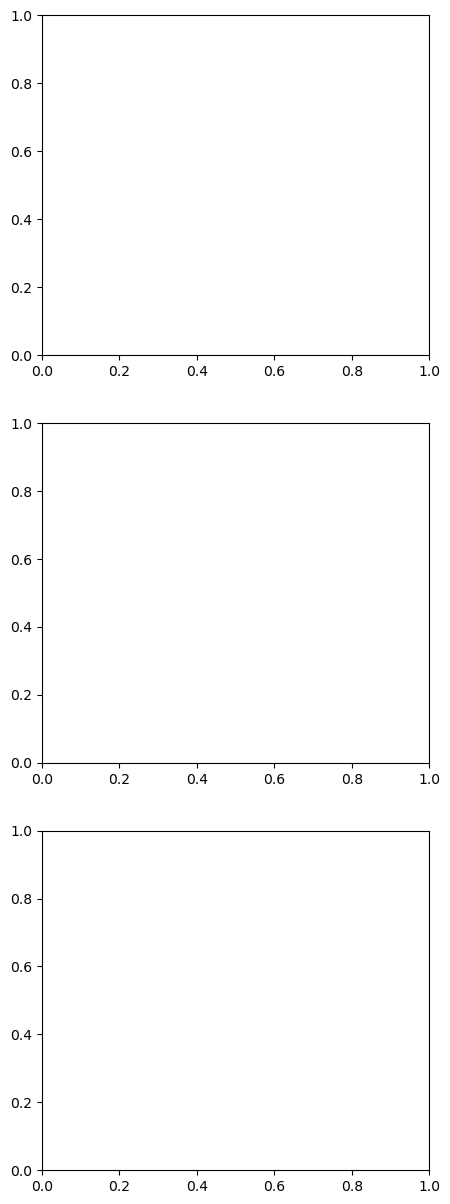

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

for station in hfrdata.keys():
    lon = hfrdata[station]['lon'].mean(dim='time')
    print(lon)
    #ax[0].plot(hfrdata[station]['lon'].sel(time=0), hfrdata[station]['lat'].sel(time=0), '.')
    #nobs = hfrdata[station]['nobs'].data